# MNIST and CIFAR-10 using CNN
## MNIST

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import torch 
import torch.nn as nn
import torch.nn.functional as F

import torchvision

In [2]:
train_data = torchvision.datasets.FashionMNIST(root="data", download=True, train=True, transform=torchvision.transforms.ToTensor())

In [3]:
test_data = torchvision.datasets.FashionMNIST(root = "data", download = True, train=False, transform=torchvision.transforms.ToTensor())

In [4]:
train_data[0]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
           0.2863, 0.0000, 0.0000, 0.0039, 

In [5]:
class_names = train_data.classes

In [6]:
print(class_names)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [7]:
len(train_data.data)

60000

<Figure size 1500x1300 with 0 Axes>

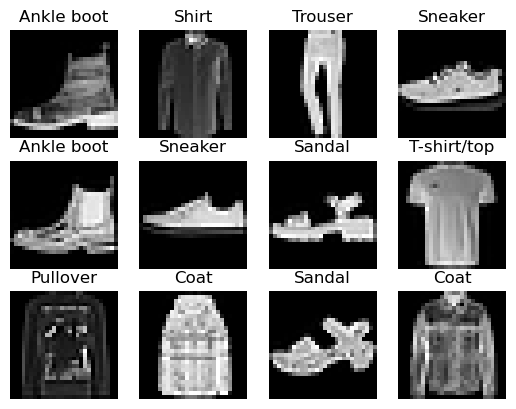

In [8]:
plt.figure(figsize=(15,13))
fig,ax = plt.subplots(nrows=3,ncols=4)

for i in range(3):
    for j in range(4):
        index = np.random.randint(60000)
        ax[i,j].imshow(np.transpose(np.array(train_data[index][0]), (1,2,0)), cmap="gray")
        ax[i,j].set_title(class_names[train_data[index][1]])
        ax[i,j].axis(False)

In [9]:
# Train the  model
class CNNModel(nn.Module):
    def __init__(self, in_features= 784, h1=120, h2=84, out_features=len(class_names)):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84, len(class_names))

    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x,2,2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x,2,2)
        x = x.view(-1,16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [11]:
model_cnn = CNNModel().to(device)

In [12]:
# Define the loss function and optimizer 
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=1e-3)

In [13]:
# Convert the data into dataloader format 
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False)

In [14]:
train_fetch_batch, train_fetch_labels = next(iter(train_dataloader))
train_fetch_batch.shape, train_fetch_labels.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

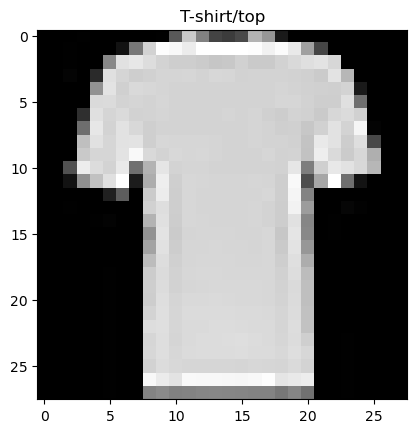

In [15]:
random_idx = torch.randint(0, len(train_fetch_batch), size=[1]).item()
img, label = train_fetch_batch[random_idx], train_fetch_labels[random_idx]
plt.imshow(np.transpose(np.array(img),(1,2,0)),cmap="gray")
plt.title(class_names[label]);

In [16]:
def accuracy_fn(y_val,y_test):
    corr = torch.eq(y_val,y_test).sum().item()
    acc = (corr / len(y_test)) * 100 
    return acc

In [17]:
import time 
from tqdm.auto import tqdm
start_time = time.time() 

# Train the model 
epochs = 5

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch} \n --------")

    train_loss = 0 
    # Add a loop through the training batches
    for batch,(X_train, y_train) in enumerate(train_dataloader):
        X_train, y_train = X_train.to(device), y_train.to(device)
        # 1. Forward pass
        y_pred = model_cnn(X_train)
        loss = criterion(y_pred, y_train)
        train_loss += loss.item()

        # Optimize zero grad
        optimizer.zero_grad()
        # Loss Backward 
        loss.backward()
        # optimizer step 
        optimizer.step()

        # print out what's happening 
        if batch%400 == 0:
            print(f"Looked at {batch * len(X_train)} / {len(train_dataloader.dataset)} samples")

    train_loss = train_loss / len(train_dataloader)

    # Testing loop 
    test_loss, test_acc = 0,0
    with torch.inference_mode():
        for X_test, y_test in test_dataloader:
            X_test, y_test = X_test.to(device), y_test.to(device)
            y_val = model_cnn(X_test)
            test_loss += criterion(y_val, y_test)
            test_acc += accuracy_fn(y_test, y_val.argmax(axis=1))

        test_loss = test_loss / len(test_dataloader)
        test_acc = test_acc / len(test_dataloader)

    # Print out what's happening 
    print(f"Testing loss: {test_loss: .4f} Test Accuracy: {test_acc:.4f}")

# Calculate the training time 
end_time = time.time()
total_train_time = end_time - start_time 

C:\Users\utkri\anaconda3\envs\pytorch_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 
 --------
Looked at 0 / 60000 samples
Looked at 12800 / 60000 samples
Looked at 25600 / 60000 samples
Looked at 38400 / 60000 samples
Looked at 51200 / 60000 samples


 20%|██        | 1/5 [00:13<00:55, 14.00s/it]

Testing loss:  0.4403 Test Accuracy: 83.3966
Epoch: 1 
 --------
Looked at 0 / 60000 samples
Looked at 12800 / 60000 samples
Looked at 25600 / 60000 samples
Looked at 38400 / 60000 samples
Looked at 51200 / 60000 samples


 40%|████      | 2/5 [00:27<00:41, 13.72s/it]

Testing loss:  0.3758 Test Accuracy: 86.3518
Epoch: 2 
 --------
Looked at 0 / 60000 samples
Looked at 12800 / 60000 samples
Looked at 25600 / 60000 samples
Looked at 38400 / 60000 samples
Looked at 51200 / 60000 samples


 60%|██████    | 3/5 [00:40<00:26, 13.43s/it]

Testing loss:  0.3474 Test Accuracy: 87.3802
Epoch: 3 
 --------
Looked at 0 / 60000 samples
Looked at 12800 / 60000 samples
Looked at 25600 / 60000 samples
Looked at 38400 / 60000 samples
Looked at 51200 / 60000 samples


 80%|████████  | 4/5 [00:53<00:13, 13.40s/it]

Testing loss:  0.3459 Test Accuracy: 87.2404
Epoch: 4 
 --------
Looked at 0 / 60000 samples
Looked at 12800 / 60000 samples
Looked at 25600 / 60000 samples
Looked at 38400 / 60000 samples
Looked at 51200 / 60000 samples


100%|██████████| 5/5 [01:07<00:00, 13.56s/it]

Testing loss:  0.3350 Test Accuracy: 87.8095


In [18]:
print(f" Total time taken is: {total_train_time} seconds.")

 Total time taken is: 67.81580829620361 seconds.


## CIFAR10

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import torch 
import torch.nn as nn
import torch.nn.functional as F

import torchvision

In [2]:
train_data = torchvision.datasets.CIFAR10(root="data", train = True, download = True, transform = torchvision.transforms.ToTensor())
test_data = torchvision.datasets.CIFAR10(root="data", train=False, download=True, transform= torchvision.transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [3]:
len(train_data), len(test_data)

(50000, 10000)

In [4]:
class_names = train_data.classes
print(class_names)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


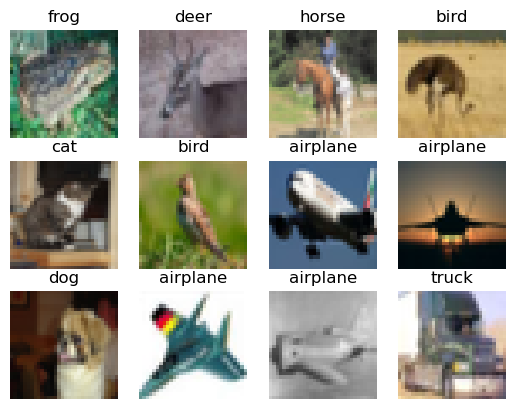

In [5]:
# Visualize the data
fig, ax = plt.subplots(nrows=3, ncols=4)


for i in range(3):
    for j in range(4):
        random_idx = torch.randint(0,len(train_data),size=[1]).item()
        ax[i,j].imshow(np.transpose(train_data[random_idx][0], (1,2,0)))
        ax[i,j].set_title(class_names[train_data[random_idx][1]])
        ax[i,j].axis(False)

plt.show();

In [6]:
# Turn the data into dataloader
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False)

In [7]:
train_data_batches, train_data_labels = next(iter(train_dataloader))
train_data_batches.shape, train_data_labels.shape

(torch.Size([32, 3, 32, 32]), torch.Size([32]))

In [8]:
len(train_dataloader)

1563

In [9]:
len(train_data) / 32

1562.5

In [10]:
# train_data_batches[1], train_data_labels[1]

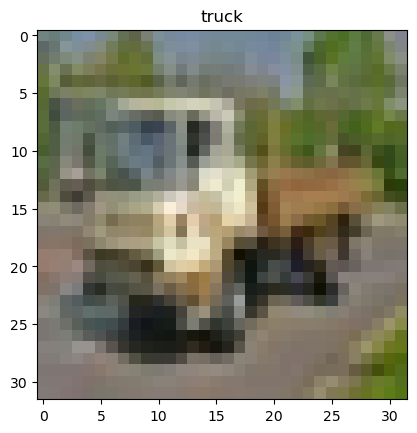

In [11]:
# Plot a figure 
random_idx = torch.randint(0,len(train_data_batches), size=[1]).item()
img, label = train_data_batches[random_idx], train_data_labels[random_idx]
plt.imshow(np.transpose(np.array(img),(1,2,0)))
plt.title(class_names[label])
plt.show();

In [12]:
# Train the model 
class CIFARModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, stride=1)
        self.bn1 = nn.BatchNorm2d(6)
        self.conv2 = nn.Conv2d(in_channels = 6, out_channels=16, kernel_size=3, stride=1)
        self.bn2 = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(16 * 6 * 6, 120)
        self.bn3 = nn.BatchNorm1d(120)
        self.fc2 = nn.Linear(120, 84)
        self.bn4 = nn.BatchNorm1d(84)
        self.drop = nn.Dropout(0.5)
        self.fc3 = nn.Linear(84,len(class_names))

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x,2,2)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x,2,2)
        x = x.view(-1, 16*6*6)
        x = F.relu(self.bn3(self.fc1(x)))
        x = F.relu(self.bn4(self.fc2(x)))
        x = self.drop(x)
        x = self.fc3(x)
        return x

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [14]:
model_cifar = CIFARModel().to(device)
model_cifar

CIFARModel(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (bn3): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (bn4): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [15]:
# Define the loss function and optimizer 
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cifar.parameters(), lr=1e-3)

In [16]:
len(train_dataloader.dataset)

50000

In [17]:
def accuracy_function(y_val, y_test):
    corr = torch.eq(y_val, y_test).sum().item()
    acc = (corr / len(y_test)) * 100
    return acc

In [18]:
# Train the model 
import time 
from tqdm.auto import tqdm 
start_time =time.time()

epochs = 5

for epoch in tqdm(range(epochs)):
    print(f"Epoch {epoch}\n ------------")
    train_loss = 0 
    for batch, (X_train, y_train) in enumerate(train_dataloader):
        X_train, y_train = X_train.to(device), y_train.to(device)
        # Forward pass
        y_pred = model_cifar(X_train)
        loss = criterion(y_pred, y_train)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch%300==0:
            print(f"Looked at: {batch * len(X_train)} / {len(train_dataloader.dataset)} samples")

    train_loss = train_loss / len(train_dataloader)

    # Testing loop 
    model_cifar.eval()
    test_loss, test_acc = 0, 0
    with torch.inference_mode():
        for X_test, y_test in test_dataloader:
            X_test, y_test = X_test.to(device), y_test.to(device)
            y_val = model_cifar(X_test)
            test_loss += criterion(y_val, y_test)
            test_acc += accuracy_function(y_test, y_val.argmax(axis=1))

        test_loss = test_loss / len(test_dataloader)
        test_acc = test_acc / len(test_dataloader)

    print(f"Testing Loss: {test_loss} Testing Accuracy: {test_acc} \n ")

end_time = time.time()

print(f"Final time taken to run the model is: {end_time - start_time} seconds.")

C:\Users\utkri\anaconda3\envs\pytorch_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0
 ------------
Looked at: 0 / 50000 samples
Looked at: 9600 / 50000 samples
Looked at: 19200 / 50000 samples
Looked at: 28800 / 50000 samples
Looked at: 38400 / 50000 samples
Looked at: 48000 / 50000 samples


 20%|██        | 1/5 [00:23<01:34, 23.67s/it]

Testing Loss: 1.247554898262024 Testing Accuracy: 55.40135782747604 
 
Epoch 1
 ------------
Looked at: 0 / 50000 samples
Looked at: 9600 / 50000 samples
Looked at: 19200 / 50000 samples
Looked at: 28800 / 50000 samples
Looked at: 38400 / 50000 samples
Looked at: 48000 / 50000 samples


 40%|████      | 2/5 [00:46<01:08, 22.93s/it]

Testing Loss: 1.2364460229873657 Testing Accuracy: 56.19009584664537 
 
Epoch 2
 ------------
Looked at: 0 / 50000 samples
Looked at: 9600 / 50000 samples
Looked at: 19200 / 50000 samples
Looked at: 28800 / 50000 samples
Looked at: 38400 / 50000 samples
Looked at: 48000 / 50000 samples


 60%|██████    | 3/5 [01:09<00:46, 23.30s/it]

Testing Loss: 1.0720056295394897 Testing Accuracy: 62.27036741214057 
 
Epoch 3
 ------------
Looked at: 0 / 50000 samples
Looked at: 9600 / 50000 samples
Looked at: 19200 / 50000 samples
Looked at: 28800 / 50000 samples
Looked at: 38400 / 50000 samples
Looked at: 48000 / 50000 samples


 80%|████████  | 4/5 [01:32<00:23, 23.10s/it]

Testing Loss: 1.0781415700912476 Testing Accuracy: 62.21046325878594 
 
Epoch 4
 ------------
Looked at: 0 / 50000 samples
Looked at: 9600 / 50000 samples
Looked at: 19200 / 50000 samples
Looked at: 28800 / 50000 samples
Looked at: 38400 / 50000 samples
Looked at: 48000 / 50000 samples


100%|██████████| 5/5 [01:51<00:00, 22.39s/it]

Testing Loss: 1.0845351219177246 Testing Accuracy: 62.47004792332268 
 
Final time taken to run the model is: 111.93153929710388 seconds.


Trying a simpler model.

In [19]:
class CIFAR2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(16*6*6, 120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84, len(class_names))

    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x,2,2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x,2,2)
        x = x.view(-1,16*6*6)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [20]:
model_2 = CIFAR2().to(device)

In [21]:
# Define the loss function and optimizer 
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr=1e-3)

In [22]:
# Train the model 
import time 
from tqdm.auto import tqdm 
start_time =time.time()

epochs = 5

for epoch in tqdm(range(epochs)):
    print(f"Epoch {epoch}\n ------------")
    train_loss = 0 
    for batch, (X_train, y_train) in enumerate(train_dataloader):
        X_train, y_train = X_train.to(device), y_train.to(device)
        # Forward pass
        y_pred = model_2(X_train)
        loss = criterion(y_pred, y_train)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch%300==0:
            print(f"Looked at: {batch * len(X_train)} / {len(train_dataloader.dataset)} samples")

    train_loss = train_loss / len(train_dataloader)

    # Testing loop 
    model_2.eval()
    test_loss, test_acc = 0, 0
    with torch.inference_mode():
        for X_test, y_test in test_dataloader:
            X_test, y_test = X_test.to(device), y_test.to(device)
            y_val = model_2(X_test)
            test_loss += criterion(y_val, y_test)
            test_acc += accuracy_function(y_test, y_val.argmax(axis=1))

        test_loss = test_loss / len(test_dataloader)
        test_acc = test_acc / len(test_dataloader)

    print(f"Testing Loss: {test_loss} Testing Accuracy: {test_acc} \n ")

end_time = time.time()

print(f"Final time taken to run the model is: {end_time - start_time} seconds.")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0
 ------------
Looked at: 0 / 50000 samples
Looked at: 9600 / 50000 samples
Looked at: 19200 / 50000 samples
Looked at: 28800 / 50000 samples
Looked at: 38400 / 50000 samples
Looked at: 48000 / 50000 samples


 20%|██        | 1/5 [00:19<01:16, 19.06s/it]

Testing Loss: 1.4835885763168335 Testing Accuracy: 45.5870607028754 
 
Epoch 1
 ------------
Looked at: 0 / 50000 samples
Looked at: 9600 / 50000 samples
Looked at: 19200 / 50000 samples
Looked at: 28800 / 50000 samples
Looked at: 38400 / 50000 samples
Looked at: 48000 / 50000 samples


 40%|████      | 2/5 [00:37<00:56, 18.79s/it]

Testing Loss: 1.3450450897216797 Testing Accuracy: 51.68730031948882 
 
Epoch 2
 ------------
Looked at: 0 / 50000 samples
Looked at: 9600 / 50000 samples
Looked at: 19200 / 50000 samples
Looked at: 28800 / 50000 samples
Looked at: 38400 / 50000 samples
Looked at: 48000 / 50000 samples


 60%|██████    | 3/5 [00:54<00:36, 18.01s/it]

Testing Loss: 1.2711752653121948 Testing Accuracy: 54.48282747603834 
 
Epoch 3
 ------------
Looked at: 0 / 50000 samples
Looked at: 9600 / 50000 samples
Looked at: 19200 / 50000 samples
Looked at: 28800 / 50000 samples
Looked at: 38400 / 50000 samples
Looked at: 48000 / 50000 samples


 80%|████████  | 4/5 [01:12<00:17, 17.74s/it]

Testing Loss: 1.2490662336349487 Testing Accuracy: 55.221645367412144 
 
Epoch 4
 ------------
Looked at: 0 / 50000 samples
Looked at: 9600 / 50000 samples
Looked at: 19200 / 50000 samples
Looked at: 28800 / 50000 samples
Looked at: 38400 / 50000 samples
Looked at: 48000 / 50000 samples


100%|██████████| 5/5 [01:31<00:00, 18.35s/it]

Testing Loss: 1.1777559518814087 Testing Accuracy: 58.36661341853035 
 
Final time taken to run the model is: 91.74958443641663 seconds.
